In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

![](http://)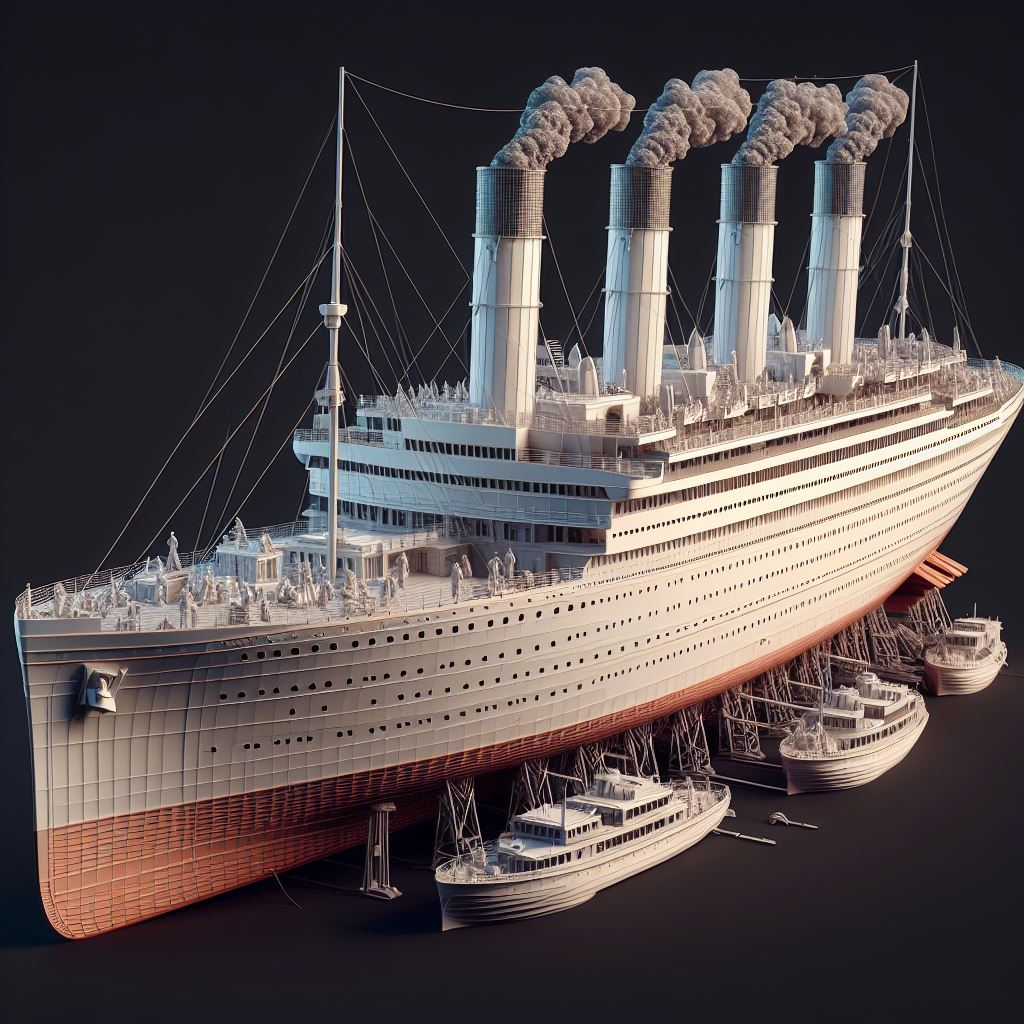

In [ ]:
train_df=pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
test_df=pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")

In [ ]:
train_df.head()

In [ ]:
train_df.info()

Here's a breakdown of the columns:

1. **PassengerId**: Object type, 8693 non-null values.
2. **HomePlanet**: Object type, 8492 non-null values.
3. **CryoSleep**: Object type, 8476 non-null values.
4. **Cabin**: Object type, 8494 non-null values.
5. **Destination**: Object type, 8511 non-null values.
6. **Age**: Float64 type, 8514 non-null values.
7. **VIP**: Object type, 8490 non-null values.
8. **RoomService**: Float64 type, 8512 non-null values.
9. **FoodCourt**: Float64 type, 8510 non-null values.
10. **ShoppingMall**: Float64 type, 8485 non-null values.
11. **Spa**: Float64 type, 8510 non-null values.
12. **VRDeck**: Float64 type, 8505 non-null values.
13. **Name**: Object type, 8493 non-null values.
14. **Transported**: Boolean type, all 8693 entries are non-null.


In [ ]:
train_df.head()

In [ ]:
train_df.isnull().sum()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

print("\nHeatmap of missing values:")
plt.figure(figsize=(12, 8))
sns.heatmap(train_df.isnull(), cbar=False, cmap='viridis')
plt.show()


In [ ]:

def combine_df(train_df, test_df):
    combined_df = pd.concat([train_df, test_df], ignore_index=True)
    return combined_df

def separate_df(combined_df, train_df_len, test_df_len):
    train_df = combined_df.iloc[:train_df_len]
    test_df = combined_df.iloc[train_df_len:train_df_len + test_df_len]
    return train_df, test_df

full_df = combine_df(train_df, test_df)
len(full_df)

In [ ]:
# List the columns we want to change
zero_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
false_columns = ['VIP']

# Condition is met if person is in CryoSleep
condition = (full_df['CryoSleep'] == True)

# Locate all rows with this condition and fill in the values for what we know them to be
full_df.loc[~condition, zero_columns] = full_df.loc[~condition, zero_columns].fillna(0)
full_df.loc[~condition, false_columns] = full_df.loc[~condition, false_columns].fillna(False)

In [ ]:
zero_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
cryosleep_column = ['CryoSleep']

# Condition is if all money columns are equal to zero
condition = (full_df[zero_columns].eq(0).all(axis=1))

#  Fill in NaN CryoSleep values as True if condition is met
full_df.loc[~condition, cryosleep_column] = full_df.loc[~condition, cryosleep_column].fillna(True)

In [ ]:
full_df['CryoSleep'].fillna(False, inplace=True)

In [ ]:
full_df.isna().sum()

In [ ]:
import missingno as msno
import matplotlib.pyplot as plt

msno.matrix(full_df)
plt.figure(figsize=(15, 9))
plt.show()

In [ ]:
# It looks like the missing values are pretty widespread throughout the data
# Lets get a closer look
msno.heatmap(full_df, labels=True) 

In [ ]:
import seaborn as sns
sample_df = full_df.sample(n=1000)

# Age has no effect on being transported
# People who spent more on roomservice were less likely to be transported
# Older people were less likely to use CryoSleep
# Not many VIP's, but the ones who were werent younger than 20
# Europans were typically older than earthlings, most martians were evenly distributed
# Europans spent more on roomservice due to outliers, earthlings spend the least on roomservice, while martians spend more overall
# This metric seems to persist throughout the data
# Most people were going to TRAPPIST, while the least were going to J318


sns.set(style='ticks')
sns.catplot(x='Destination', y='Age', kind='swarm', data=sample_df, s=2)
plt.show()

In [ ]:
sns.countplot(x='Destination',hue='VIP', data=full_df)
plt.show()
# Nobody chose VIP if they were in CryoSleep, so any people with VIP should have CryoSleep filled in as false
# Most Earthlings were going to Trappist, so just fill in both earth and mars with trappist
# Europa is half and half between trappist and 55 Cancri e, perhaps fill in half with each, otherwise just leave it be

In [ ]:
# First, lets separate the data in the cabin column into it's respective pieces of data
cabin_split = full_df['Cabin'].str.split('/', expand=True)
cabin_split.columns = ['Deck', 'Room_Number', 'Side']
new_df = pd.concat([full_df, cabin_split], axis=1)
full_df = new_df
full_df.drop(columns=['Cabin'], inplace=True)
full_df.head()

In [ ]:
group_means = full_df.groupby(['HomePlanet', 'CryoSleep'])['Age'].mean()
print(group_means)

In [ ]:
# Fill in NaN values for Age
group_means = full_df.groupby(['HomePlanet', 'CryoSleep'], group_keys=True)['Age'].mean().reset_index(name='Age_mean')
full_df = full_df.merge(group_means, on=['HomePlanet', 'CryoSleep'], how='left')
full_df['Age'] = full_df['Age'].fillna(full_df['Age_mean'])
full_df.drop(columns=['Age_mean'], inplace=True)


In [ ]:
full_df.isna().sum()

In [ ]:
# Now we can continue with imputing/preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer


# Specify numerical and categorical features
numerical_features = ['Room_Number', 'Age', 'RoomService', 'FoodCourt','ShoppingMall','Spa','VRDeck']
categorical_features = ['HomePlanet','CryoSleep','Destination','VIP','Deck', 'Side']

# Create preprocessing pipelines for numerical and categorical features
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('inputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine pipelines using ColumnTransformer
preprocessor = ColumnTransformer([
    ('numerical', numerical_pipeline, numerical_features),
    ('categorical', categorical_pipeline, categorical_features)
])

In [ ]:
train_df_len = len(train_df)
train_df_len

In [ ]:
test_df_len = len(test_df)
test_df_len

In [ ]:
# Separate DF back into respective DF's
train_df, test_df = separate_df(full_df,train_df_len,test_df_len)

# Set up target
y = train_df['Transported']

# Take target out of both train and test sets
train_df.drop(columns=['Transported'], inplace=True)
test_df.drop(columns=['Transported'], inplace=True)

# Y needs to be changed to actual binary values instead of strings
y = y.astype(bool)
y.head()

In [ ]:
# Need this for later
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
SEED = 42

In [ ]:
# Shape before transformation
print('X_train shape: {}'.format(train_df.shape))
print('y_train shape: {}'.format(y.shape))
print('X_test shape: {}'.format(test_df.shape))

In [ ]:
# Fit data to preprocessor, and clean the data, rename columns to correct names afterwards
transformed_data_train = preprocessor.fit_transform(train_df)
transformed_data_test = preprocessor.transform(test_df)

feature_names = preprocessor.named_transformers_['categorical'] \
    .named_steps['encoder'].get_feature_names_out(input_features=categorical_features) 

all_feature_names = numerical_features + list(feature_names)

In [ ]:
# Turns data into dataframes
transformed_train_df = pd.DataFrame(transformed_data_train, columns = all_feature_names)
transformed_test_df = pd.DataFrame(transformed_data_test, columns = all_feature_names)

In [ ]:
# Transformed data check to make sure train and test have same # of categories
print('X_train shape: {}'.format(transformed_train_df.shape))
print('y_train shape: {}'.format(y.shape))
print('X_test shape: {}'.format(transformed_test_df.shape))

In [ ]:
# Fit data to preprocessor, and clean the data, rename columns to correct names afterwards
transformed_data_train = preprocessor.fit_transform(train_df)
transformed_data_test = preprocessor.transform(test_df)

feature_names = preprocessor.named_transformers_['categorical'] \
    .named_steps['encoder'].get_feature_names_out(input_features=categorical_features) 

all_feature_names = numerical_features + list(feature_names)

In [ ]:
# Turns data into dataframes
transformed_train_df = pd.DataFrame(transformed_data_train, columns = all_feature_names)
transformed_test_df = pd.DataFrame(transformed_data_test, columns = all_feature_names)

In [ ]:
# Transformed data check to make sure train and test have same # of categories
print('X_train shape: {}'.format(transformed_train_df.shape))
print('y_train shape: {}'.format(y.shape))
print('X_test shape: {}'.format(transformed_test_df.shape))

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

# better model overall, performed better on data with less overfitting
#forest_model = RandomForestClassifier(criterion='gini', n_estimators=70, max_depth=5, min_samples_split=2, min_samples_leaf=2,
#                                       max_features='sqrt', random_state=SEED)

# First GBM Model
gbm_model_1 = GradientBoostingClassifier(n_estimators=70, learning_rate=0.1, max_features='sqrt', max_depth=5, random_state=SEED, 
                                        min_samples_split=2, min_samples_leaf=3, loss='exponential', subsample=0.5)

# Second GBM Model
gbm_model_2 = GradientBoostingClassifier(n_estimators=70, learning_rate=0.1, max_features='log2', max_depth=5, random_state=SEED, 
                                        min_samples_split=2, min_samples_leaf=3, subsample=0.5, loss='log_loss')

# Third GBM Model
gbm_model_3 = GradientBoostingClassifier(n_estimators=70, learning_rate=0.1, max_features='log2', max_depth=5, random_state=SEED, 
                                        min_samples_split=2, min_samples_leaf=3, subsample=0.5, loss='exponential')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(transformed_train_df, y, test_size=0.2, random_state=SEED)

In [ ]:
from sklearn.metrics import accuracy_score

# Fit both models
gbm_model_1.fit(X_train, y_train)
gbm_model_2.fit(X_train, y_train)
gbm_model_3.fit(X_train, y_train)

# Run through predictions initially to train the Logistic Regression for predicting
gbm_1_predictions = gbm_model_1.predict(X_test)
gbm_2_predictions = gbm_model_2.predict(X_test)
gbm_3_predictions = gbm_model_3.predict(X_test)


# Stack both predictions to form a training set for the Logistic Regression
stacked_features = np.column_stack((gbm_1_predictions, gbm_2_predictions, gbm_3_predictions))

# Fit the meta model to stacked features
meta_model = LogisticRegression()
meta_model.fit(stacked_features, y_test)

# Predict yet again to get a new metric
gbm_1_base_preds = gbm_model_1.predict(X_test)
gbm_2_base_preds = gbm_model_2.predict(X_test)
gbm_3_base_preds = gbm_model_3.predict(X_test)

# Stack both predictions yet again
stacked_base_preds = np.column_stack((gbm_1_base_preds, gbm_2_base_preds, gbm_3_base_preds))

# Get final predictions to gauge overall performance
ensemble_predictions = meta_model.predict(stacked_base_preds)

# Score the predictions and print them
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
print("Ensemble Accuracy:", ensemble_accuracy)

In [ ]:
# Get new base predictions for actual test set
gbm_1_base_preds = gbm_model_1.predict(transformed_test_df)
gbm_2_base_preds = gbm_model_2.predict(transformed_test_df)
gbm_3_base_preds = gbm_model_3.predict(transformed_test_df)

# Combine both predictions for the meta model to predict
stacked_base_preds = np.column_stack((gbm_1_base_preds, gbm_2_base_preds, gbm_3_base_preds))

In [ ]:
# Actually predict the final result
ensemble_predictions = meta_model.predict(stacked_base_preds)

In [ ]:
output = pd.DataFrame({
    'PassengerId' : test_df['PassengerId'],
    'Transported' : ensemble_predictions
})
output.to_csv('submission.csv', index=False)
print('Submission Saved')